# EPC Dataset Analysis for Energy Rating Prediction
This notebook presents a complete data science pipeline for analyzing the Birmingham EPC (Energy Performance Certificate) dataset. The goal is to predict the **Potential Energy Rating** of properties based on various features extracted from the EPC certificates and recommendations data.

## Task Objective

We aim to build a machine learning model that predicts a property's **Potential Energy Rating** based on the data provided in the **UK Energy Performance Certificates (EPC)** dataset.

This notebook will:
- Perform data loading and preprocessing
- Engineer useful features
- Train and evaluate multiple ML models
- Select the best model based on performance
- Prepare the model for deployment in an API and dashboard interface

---

## Dataset Overview

We are using two datasets:

1. **certificates.csv**
   - Contains 93 features per property
   - Includes both `CURRENT_ENERGY_RATING` and `POTENTIAL_ENERGY_RATING`

2. **recommendations.csv**
   - Lists possible energy-saving improvements per property
   - Can be joined to `certificates.csv` using the `LMK_KEY`

---

## Target Variable

- `POTENTIAL_ENERGY_RATING`: Categorical (A to G), mapped to ordinal scale 0 (A) → 6 (G)

---

## Problem Type

- **Multi-Class Classification**
- Goal: Predict energy efficiency category based on property features

---

## Machine Learning Models to Compare

| Model              | Justification                      |
|-------------------|------------------------------------|
| XGBoost            | High performance in literature     |
| Random Forest      | Robust and interpretable baseline  |
| MLPClassifier      | Deep learning (neural network)     |
| CatBoost           | Handles categoricals natively      |
| Logistic Regression| Lightweight and interpretable      |

---


### STEP 1: Loading the Data and Initial Exploration

#### Load EPC Certificates and Recommendations Data

In this step, we load:
- `certificates.csv`
- `recommendations.csv`

This prepares both core datasets needed for merging and model development.

In [1]:
!pip install pandas matplotlib seaborn scikit-learn imblearn xgboost

In [ ]:
# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Models
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Evaluation
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Utilities
import os
import pickle

In [3]:
# Load the certificates dataset
cert_df = pd.read_csv("../data/certificates.csv")

# Load the recommendations dataset
reco_df = pd.read_csv("../data/recommendations.csv")

# Display dataset shapes
print("Certificates shape:", cert_df.shape)
print("Recommendations shape:", reco_df.shape)

# Preview top rows
cert_df.head(3)


/tmp/ipykernel_27789/1871763329.py:2: DtypeWarning: Columns (15,37,83) have mixed types. Specify dtype option on import or set low_memory=False.
  cert_df = pd.read_csv("../data/certificates.csv")


Certificates shape: (515259, 93)
Recommendations shape: (2015386, 7)


,LMK_KEY,ADDRESS1,ADDRESS2,ADDRESS3,POSTCODE,BUILDING_REFERENCE_NUMBER,CURRENT_ENERGY_RATING,POTENTIAL_ENERGY_RATING,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,...,CONSTITUENCY_LABEL,POSTTOWN,CONSTRUCTION_AGE_BAND,LODGEMENT_DATETIME,TENURE,FIXED_LIGHTING_OUTLETS_COUNT,LOW_ENERGY_FIXED_LIGHT_COUNT,UPRN,UPRN_SOURCE,REPORT_TYPE
0,20e1e1bb26a2f936fc00cac1c80f8126d0e259d1a134df...,30 Hazeldene Road,NaN,NaN,B33 0QB,10002236335,C,B,69,83,...,"Birmingham, Yardley",BIRMINGHAM,England and Wales: 1991-1995,2022-11-10 17:11:02,Rented (social),9.0,NaN,1.002445e+10,Energy Assessor,100
1,000ae64d8e85cbcdb5c013cde937d5a3e629b762c4fa77...,6 Cotteridge Road,NaN,NaN,B30 3AZ,10003893455,D,B,65,82,...,"Birmingham, Selly Oak",BIRMINGHAM,England and Wales: 1900-1929,2023-01-16 14:55:47,Owner-occupied,16.0,NaN,1.000703e+11,Energy Assessor,100
2,0019b15f7ca83293409965f80cbac76b6e16ea6a7e72da...,Flat B,32 Trafalgar Road,Moseley,B13 8BH,10003927002,D,C,55,72,...,"Birmingham, Hall Green",BIRMINGHAM,England and Wales: 1900-1929,2023-01-24 17:12:59,Rented (social),6.0,NaN,1.000713e+11,Energy Assessor,100


#### Check Dataset Columns and Missing Values

We'll examine:
- The full list of columns in both datasets
- The top 10 columns with the most missing values

In [4]:
# Show column names for both datasets
print("Certificates Columns:")
print(cert_df.columns.tolist())

print("\nRecommendations Columns:")
print(reco_df.columns.tolist())

Certificates Columns:
['LMK_KEY', 'ADDRESS1', 'ADDRESS2', 'ADDRESS3', 'POSTCODE', 'BUILDING_REFERENCE_NUMBER', 'CURRENT_ENERGY_RATING', 'POTENTIAL_ENERGY_RATING', 'CURRENT_ENERGY_EFFICIENCY', 'POTENTIAL_ENERGY_EFFICIENCY', 'PROPERTY_TYPE', 'BUILT_FORM', 'INSPECTION_DATE', 'LOCAL_AUTHORITY', 'CONSTITUENCY', 'COUNTY', 'LODGEMENT_DATE', 'TRANSACTION_TYPE', 'ENVIRONMENT_IMPACT_CURRENT', 'ENVIRONMENT_IMPACT_POTENTIAL', 'ENERGY_CONSUMPTION_CURRENT', 'ENERGY_CONSUMPTION_POTENTIAL', 'CO2_EMISSIONS_CURRENT', 'CO2_EMISS_CURR_PER_FLOOR_AREA', 'CO2_EMISSIONS_POTENTIAL', 'LIGHTING_COST_CURRENT', 'LIGHTING_COST_POTENTIAL', 'HEATING_COST_CURRENT', 'HEATING_COST_POTENTIAL', 'HOT_WATER_COST_CURRENT', 'HOT_WATER_COST_POTENTIAL', 'TOTAL_FLOOR_AREA', 'ENERGY_TARIFF', 'MAINS_GAS_FLAG', 'FLOOR_LEVEL', 'FLAT_TOP_STOREY', 'FLAT_STOREY_COUNT', 'MAIN_HEATING_CONTROLS', 'MULTI_GLAZE_PROPORTION', 'GLAZED_TYPE', 'GLAZED_AREA', 'EXTENSION_COUNT', 'NUMBER_HABITABLE_ROOMS', 'NUMBER_HEATED_ROOMS', 'LOW_ENERGY_LIGHTING

In [5]:
# Show top columns with missing values in certificates
print("Missing Values in Certificates Dataset:")
print(cert_df.isnull().sum().sort_values(ascending=False).head(10))

# Show top columns with missing values in recommendations
print("\nMissing Values in Recommendations Dataset:")
print(reco_df.isnull().sum().sort_values(ascending=False).head(10))

Missing Values in Certificates Dataset:
SHEATING_ENERGY_EFF             515259
SHEATING_ENV_EFF                515259
COUNTY                          515256
FLOOR_ENV_EFF                   495844
FLAT_STOREY_COUNT               481128
ADDRESS3                        459629
UNHEATED_CORRIDOR_LENGTH        426123
FLOOR_ENERGY_EFF                365454
LOW_ENERGY_FIXED_LIGHT_COUNT    343260
FLAT_TOP_STOREY                 337569
dtype: int64

Missing Values in Recommendations Dataset:
IMPROVEMENT_ID_TEXT         2015386
INDICATIVE_COST              322003
IMPROVEMENT_ID               157231
IMPROVEMENT_SUMMARY_TEXT     156381
LMK_KEY                           0
IMPROVEMENT_ITEM                  0
IMPROVEMENT_DESCR_TEXT            0
dtype: int64


#### Explore Feature Distributions

We'll explore and visualize:
- Current and potential energy ratings
- Property types
- Built form

This gives us a sense of class imbalance and dominant property features.

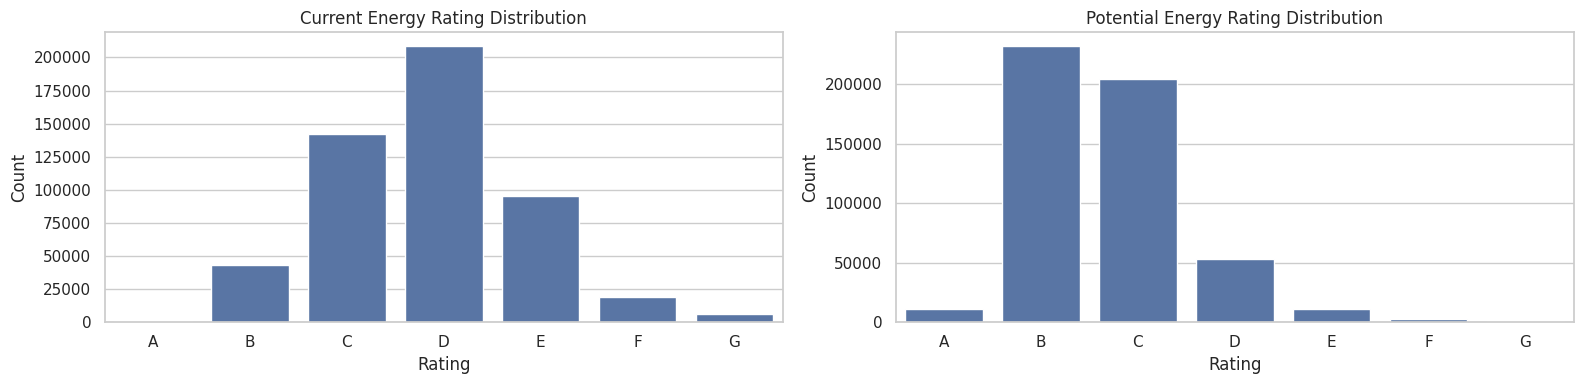

In [6]:
# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(16, 4))

# Plot energy rating distributions
plt.subplot(1, 2, 1)
sns.countplot(data=cert_df, x='CURRENT_ENERGY_RATING', order=sorted(cert_df['CURRENT_ENERGY_RATING'].dropna().unique()))
plt.title("Current Energy Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(data=cert_df, x='POTENTIAL_ENERGY_RATING', order=sorted(cert_df['POTENTIAL_ENERGY_RATING'].dropna().unique()))
plt.title("Potential Energy Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

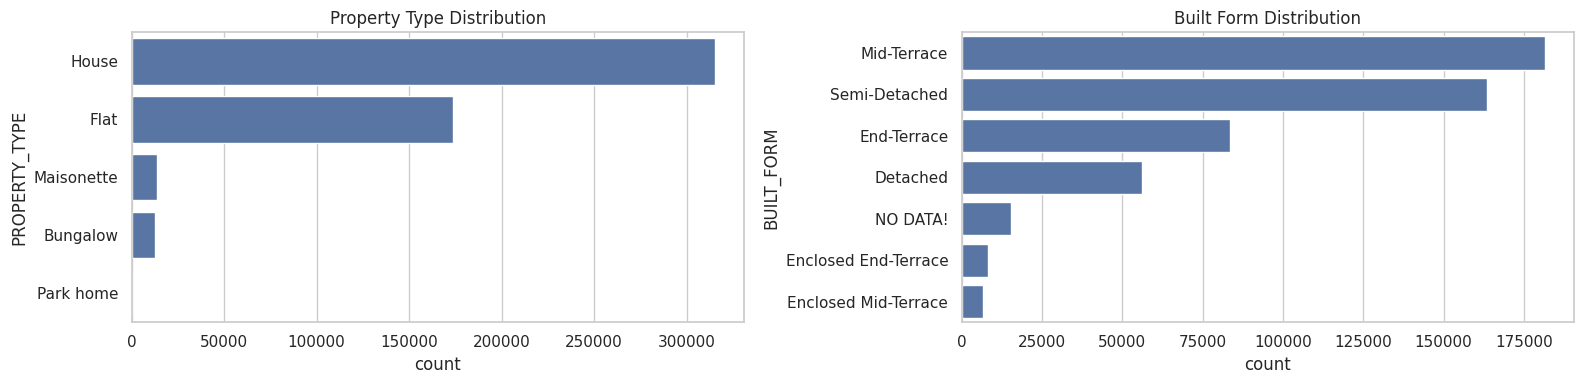

In [7]:
# Plot Property Type and Built Form
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
sns.countplot(data=cert_df, y='PROPERTY_TYPE', order=cert_df['PROPERTY_TYPE'].value_counts().index)
plt.title("Property Type Distribution")

plt.subplot(1, 2, 2)
sns.countplot(data=cert_df, y='BUILT_FORM', order=cert_df['BUILT_FORM'].value_counts().index)
plt.title("Built Form Distribution")

plt.tight_layout()
plt.show()


#### Check LMK_KEY Join Coverage

We'll verify how many `LMK_KEY` entries in the recommendations dataset match with those in the certificates dataset. This helps us understand:
- Whether it's meaningful to merge the recommendations
- What percentage of the rows will be enriched

In [8]:
# Percentage of recommendations that can be matched with certificate entries
match_percentage = reco_df['LMK_KEY'].isin(cert_df['LMK_KEY']).mean() * 100
unmatched_count = (~reco_df['LMK_KEY'].isin(cert_df['LMK_KEY'])).sum()

print(f"{match_percentage:.2f}% of recommendations match with certificate LMK_KEYs")
print(f"{unmatched_count} recommendation rows do not have a matching certificate")

100.00% of recommendations match with certificate LMK_KEYs
0 recommendation rows do not have a matching certificate


### STEP 2: Data Preprocessing

#### Aggregate and Merge Recommendations into Certificates

The `recommendations.csv` file contains multiple suggested improvements per property. To avoid data duplication and maintain a one-row-per-property structure:

1. We **aggregate** the data by `LMK_KEY`:
   - Count of unique `IMPROVEMENT_ID`s → `N_RECOMMENDATIONS`
   - Concatenated improvement texts → `ALL_RECOMMENDATIONS`

2. We then **merge** this summary back into the `certificates.csv` dataset.

This ensures the dataset remains clean and prevents duplicated rows for each improvement.

In [9]:
# Aggregate recommendations: count & concatenate text
reco_agg = reco_df.groupby("LMK_KEY").agg({
    "IMPROVEMENT_ID": "nunique",
    "IMPROVEMENT_SUMMARY_TEXT": lambda x: ', '.join(set(x.dropna()))
}).reset_index().rename(columns={
    "IMPROVEMENT_ID": "N_RECOMMENDATIONS",
    "IMPROVEMENT_SUMMARY_TEXT": "ALL_RECOMMENDATIONS"
})

# Merge into certificates dataset (preserving one row per LMK_KEY)
df_merged = pd.merge(cert_df, reco_agg, on="LMK_KEY", how="left")

# Show shape and preview
print("Merged shape:", df_merged.shape)
df_merged.head(3)

Merged shape: (515259, 95)


,LMK_KEY,ADDRESS1,ADDRESS2,ADDRESS3,POSTCODE,BUILDING_REFERENCE_NUMBER,CURRENT_ENERGY_RATING,POTENTIAL_ENERGY_RATING,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,...,CONSTRUCTION_AGE_BAND,LODGEMENT_DATETIME,TENURE,FIXED_LIGHTING_OUTLETS_COUNT,LOW_ENERGY_FIXED_LIGHT_COUNT,UPRN,UPRN_SOURCE,REPORT_TYPE,N_RECOMMENDATIONS,ALL_RECOMMENDATIONS
0,20e1e1bb26a2f936fc00cac1c80f8126d0e259d1a134df...,30 Hazeldene Road,NaN,NaN,B33 0QB,10002236335,C,B,69,83,...,England and Wales: 1991-1995,2022-11-10 17:11:02,Rented (social),9.0,NaN,1.002445e+10,Energy Assessor,100,3.0,"Solar photovoltaic panels, 2.5 kWp, Floor insu..."
1,000ae64d8e85cbcdb5c013cde937d5a3e629b762c4fa77...,6 Cotteridge Road,NaN,NaN,B30 3AZ,10003893455,D,B,65,82,...,England and Wales: 1900-1929,2023-01-16 14:55:47,Owner-occupied,16.0,NaN,1.000703e+11,Energy Assessor,100,4.0,"Internal or external wall insulation, Solar ph..."
2,0019b15f7ca83293409965f80cbac76b6e16ea6a7e72da...,Flat B,32 Trafalgar Road,Moseley,B13 8BH,10003927002,D,C,55,72,...,England and Wales: 1900-1929,2023-01-24 17:12:59,Rented (social),6.0,NaN,1.000713e+11,Energy Assessor,100,2.0,"Internal or external wall insulation, Room-in-..."


#### Drop Duplicate Rows

Although `LMK_KEY` is unique, we drop any fully duplicated rows as a safety measure.  
This ensures we have truly unique examples before modeling.

In [10]:
# Drop fully duplicated rows (across all columns)
before = df_merged.shape[0]
df_merged.drop_duplicates(inplace=True)
after = df_merged.shape[0]

print(f"Dropped {before - after} duplicate rows. Remaining rows: {after}")

Dropped 0 duplicate rows. Remaining rows: 515259


#### Drop Irrelevant Columns

Some fields in the EPC dataset are not useful for prediction and may introduce noise. We drop:

- Address fields (`ADDRESS1`, `ADDRESS2`, `POSTCODE`, etc.)
- Identifiers (`LMK_KEY`, `BUILDING_REFERENCE_NUMBER`, `UPRN`, etc.)
- Timestamps (`LODGE_DATE`, `INSPECTION_DATE`, `LODGE_DATETIME`)
- Postal info (`POSTTOWN`, `CONSTITUENCY`, `LOCAL_AUTHORITY`)

These are dropped to simplify the feature space and improve generalization.

In [11]:
# Drop columns by pattern
drop_cols = [col for col in df_merged.columns if
             'ADDRESS' in col or
             'POSTCODE' in col or
             'DATETIME' in col or
             'DATE' in col or
             'LMK_KEY' in col or
             'UPRN' in col or
             'BUILDING_REFERENCE' in col or
             'POSTTOWN' in col or
             'LOCAL_AUTHORITY' in col or
             'CONSTITUENCY' in col]

df_merged.drop(columns=drop_cols, inplace=True)

print("Cleaned shape after dropping irrelevant columns:", df_merged.shape)

Cleaned shape after dropping irrelevant columns: (515259, 78)


#### Remove Columns with High Missing Values

To ensure model stability and avoid noisy features, we drop any column where more than **50% of the values are missing**.

In [12]:
# Calculate missing fraction for each column
missing_frac = df_merged.isnull().mean()

# Identify columns where more than 50% of values are missing
high_na_cols = missing_frac[missing_frac > 0.5].index.tolist()

# Drop those columns
df_merged.drop(columns=high_na_cols, inplace=True)

print(f"Dropped {len(high_na_cols)} columns with >50% missing values")
print("Shape after drop:", df_merged.shape)

Dropped 10 columns with >50% missing values
Shape after drop: (515259, 68)


#### Drop Rows Missing Essential Columns

We remove rows that are missing **key fields** required for both feature analysis and model training.

These fields include:
- `CURRENT_ENERGY_RATING` - required for comparison
- `POTENTIAL_ENERGY_RATING` - the prediction target
- `PROPERTY_TYPE`, `BUILT_FORM` - high-impact categorical features

In [13]:
# Define required columns
required_cols = ['CURRENT_ENERGY_RATING', 'POTENTIAL_ENERGY_RATING', 'PROPERTY_TYPE', 'BUILT_FORM']

# Drop rows with missing values in required columns
df_merged.dropna(subset=required_cols, inplace=True)

print("Shape after dropping rows with NA in essential fields:", df_merged.shape)

Shape after dropping rows with NA in essential fields: (514957, 68)


#### Drop Duplicate Feature Vectors

Some properties in the EPC dataset have identical feature values despite different `LMK_KEY`s, due to uniform housing structure, imputation, or similar energy profiles.

To prevent **identical rows from leaking into both training and test sets**, we remove all exact duplicates across feature columns (excluding the target).


In [14]:
# Drop duplicate feature vectors and reassign to df_merged
columns_to_check = df_merged.select_dtypes(include=['number']).columns.tolist()

# Drop duplicates
df_merged = df_merged.drop_duplicates(subset=columns_to_check)

print(f"df_merged shape after dropping duplicate feature vectors: {df_merged.shape}")

df_merged shape after dropping duplicate feature vectors: (490406, 68)


#### Encode Categorical Features

We handle two types of categorical variables:

1. **Ordinal Encoding**:
   - `CURRENT_ENERGY_RATING` and `POTENTIAL_ENERGY_RATING`
   - These have a natural order: A > B > C > ... > G
   - We map them to integers: A=0, B=1, ..., G=6

2. **One-Hot Encoding**:
   - For nominal categorical features such as `PROPERTY_TYPE`, `BUILT_FORM`, `GLAZED_TYPE`, `TENURE`, and `CONSTRUCTION_AGE_BAND`
   - These are expanded into binary columns using `pd.get_dummies()`

In [15]:
# Encode ordinal ratings
ordinal_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
df_merged['CURRENT_ENERGY_RATING'] = df_merged['CURRENT_ENERGY_RATING'].map(ordinal_map)
df_merged['POTENTIAL_ENERGY_RATING'] = df_merged['POTENTIAL_ENERGY_RATING'].map(ordinal_map)

# One-hot encode nominal categorical features
nominal_cols = ['PROPERTY_TYPE', 'BUILT_FORM', 'GLAZED_TYPE', 'TENURE', 'CONSTRUCTION_AGE_BAND']
df_merged = pd.get_dummies(df_merged, columns=nominal_cols, drop_first=True)

print("Shape after encoding:", df_merged.shape)


Shape after encoding: (490406, 119)


### Step 3: Feature Engineering

We create new features based on domain knowledge:

1. `TOTAL_COST_CURRENT`: Combined cost of lighting, heating, and hot water
2. `COST_PER_AREA`: Total energy cost per square metre
3. `CO2_PER_AREA`: CO2 emissions per square metre

In [16]:
# 1. Total current energy cost
df_merged['TOTAL_COST_CURRENT'] = df_merged[['LIGHTING_COST_CURRENT', 'HEATING_COST_CURRENT', 'HOT_WATER_COST_CURRENT']].sum(axis=1)

# 2. Cost per floor area
df_merged['COST_PER_AREA'] = df_merged['TOTAL_COST_CURRENT'] / df_merged['TOTAL_FLOOR_AREA']

# 3. CO2 per floor area
df_merged['CO2_PER_AREA'] = df_merged['CO2_EMISSIONS_CURRENT'] / df_merged['TOTAL_FLOOR_AREA']

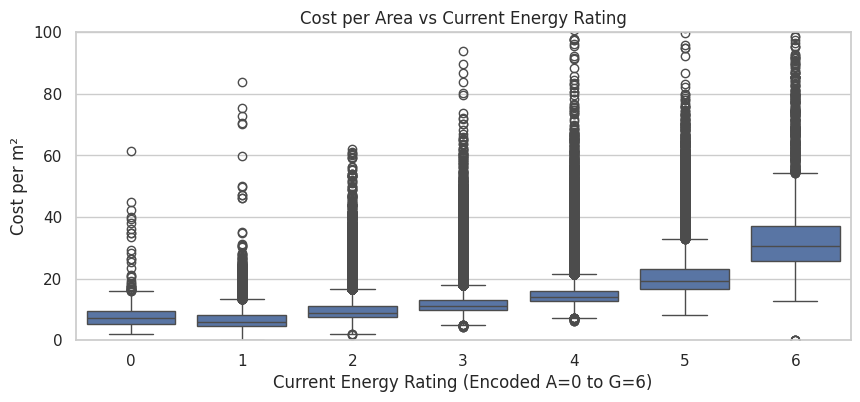

In [17]:
# Boxplot: cost per area by current energy rating
plt.figure(figsize=(10, 4))
sns.boxplot(x='CURRENT_ENERGY_RATING', y='COST_PER_AREA', data=df_merged)
plt.title("Cost per Area vs Current Energy Rating")
plt.xlabel("Current Energy Rating (Encoded A=0 to G=6)")
plt.ylabel("Cost per m²")
plt.ylim(0, 100)  # Limit outliers
plt.show()

#### Handle Infinite and Extreme Values

After creating derived features like `COST_PER_AREA` or `CO2_PER_AREA`, we may introduce:

- `inf` or `-inf` values from division by zero
- Extremely large outliers due to small floor area

We fix these now to avoid crashing model training later.

In [18]:
# Replace infinite values with NaN
df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)

print("Infinite and extreme values handled.")

Infinite and extreme values handled.


#### Final Cleanup and Define Feature Matrix (X) and Target (y)

Before moving into modeling, we:
- Drop remaining rows with missing values (if any)
- Define the potential target leakage columns in `X` and target vector `y`
- Confirm data types and shapes


In [19]:
# Define all critical columns required for modeling
requested_critical_cols = [
    'POTENTIAL_ENERGY_RATING_ENC', 'CURRENT_ENERGY_RATING_ENC',
    'TOTAL_COST_CURRENT', 'COST_PER_AREA', 'CO2_PER_AREA'
]

# Filter only those that actually exist in df_merged
critical_model_cols = [col for col in requested_critical_cols if col in df_merged.columns]

# Drop rows where any of the existing critical columns are missing
df_merged.dropna(subset=critical_model_cols, inplace=True)

# Define target and leakage features
target = 'POTENTIAL_ENERGY_RATING'

leakage_cols = [
    'ENVIRONMENT_IMPACT_POTENTIAL',
    'ENERGY_CONSUMPTION_POTENTIAL',
    'CO2_EMISSIONS_POTENTIAL',
    'LIGHTING_COST_POTENTIAL',
    'HEATING_COST_POTENTIAL',
    'HOT_WATER_COST_POTENTIAL',
    target
]

X = df_merged.select_dtypes(include=['int64', 'float64']).drop(columns=leakage_cols, errors='ignore')
X = X.drop(columns=leakage_cols, errors='ignore')

y = df_merged[target]

# Output shape check
print("Fixed X shape:", X.shape)
print("Fixed y shape:", y.shape)
print("Target distribution:\n", y.value_counts(normalize=True).sort_index())


Fixed X shape: (490102, 26)
Fixed y shape: (490102,)
Target distribution:
 POTENTIAL_ENERGY_RATING
0    0.018437
1    0.450827
2    0.397389
3    0.104089
4    0.021640
5    0.005348
6    0.002271
Name: proportion, dtype: float64


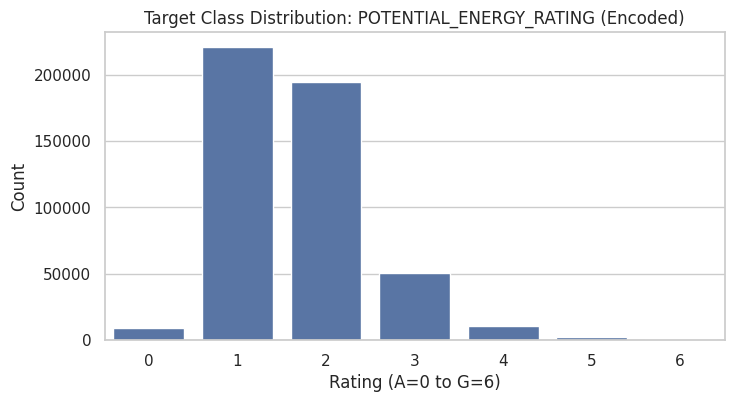

In [20]:
plt.figure(figsize=(8, 4))
sns.countplot(x=y)
plt.title("Target Class Distribution: POTENTIAL_ENERGY_RATING (Encoded)")
plt.xlabel("Rating (A=0 to G=6)")
plt.ylabel("Count")
plt.show()

#### Impute Missing Values(NaN)

We use `SimpleImputer(strategy='median')` to fill missing values in all numeric columns. This:
- Prevents data loss (vs. dropping rows)
- Ensures compatibility with most ML models

In [21]:
# Impute missing values with median
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Rebuild as DataFrame (retain column names)
X = pd.DataFrame(X_imputed, columns=X.columns)

print("X shape after imputation:", X.shape)

X shape after imputation: (490102, 26)



### STEP 4: Feature Selection

This step ensures we remove:

* **Highly correlated features** (to avoid multicollinearity)
* **Low-variance features** (which don’t help prediction)

#### Remove Highly Correlated Features

We'll:
- Compute a correlation matrix
- Drop one of each pair of features with correlation > 0.90
- This reduces redundancy and overfitting in models like logistic regression and neural networks


In [22]:
# Drop leaky features
leaky_features = [
    'CURRENT_ENERGY_EFFICIENCY', 'POTENTIAL_ENERGY_EFFICIENCY',
    'ENERGY_CONSUMPTION_CURRENT', 'CO2_EMISSIONS_CURRENT',
    'LIGHTING_COST_CURRENT', 'HEATING_COST_CURRENT', 'HOT_WATER_COST_CURRENT'
]
X.drop(columns=[col for col in leaky_features if col in X.columns], inplace=True)

# Select only numeric features
numeric_features = X.select_dtypes(include=['number'])

# Drop highly correlated numeric columns
corr_matrix = numeric_features.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_cols = [column for column in upper.columns if any(upper[column] > 0.90)]

X.drop(columns=high_corr_cols, inplace=True)

print(f"Dropped {len(high_corr_cols)} highly correlated numeric features")

# Check final shapes
print("Final X shape:", X.shape)
print("Final y shape:", y.shape)
print("Target distribution:\n", y.value_counts(normalize=True).sort_index())


Dropped 3 highly correlated numeric features
Final X shape: (490102, 16)
Final y shape: (490102,)
Target distribution:
 POTENTIAL_ENERGY_RATING
0    0.018437
1    0.450827
2    0.397389
3    0.104089
4    0.021640
5    0.005348
6    0.002271
Name: proportion, dtype: float64


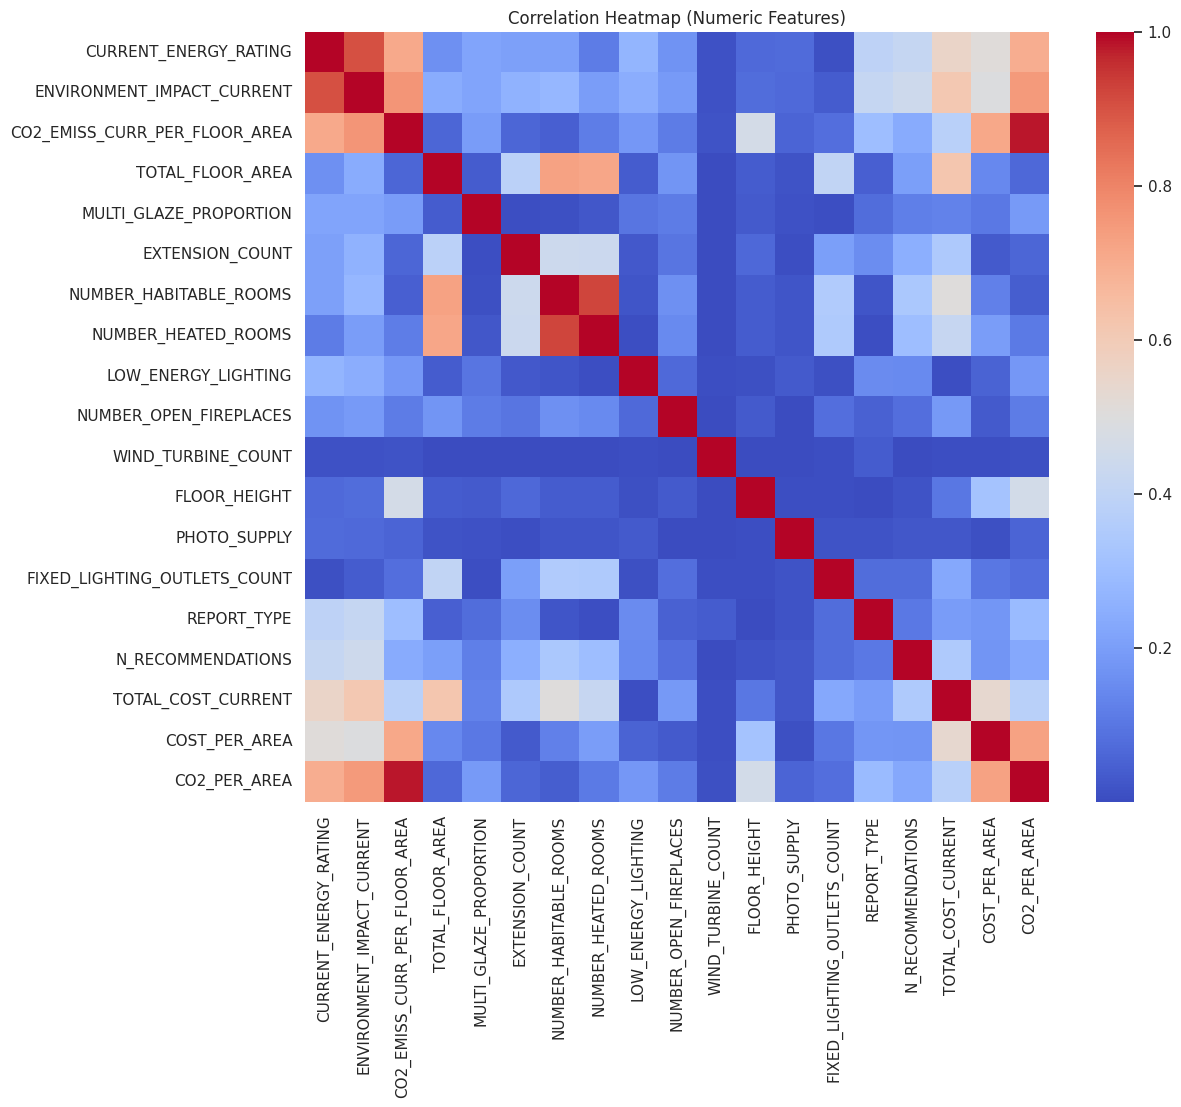

In [23]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

#### Remove Near-Zero Variance Features

Features with very little variation (e.g., almost all 0s or constants) do not contribute to learning and can be removed.

We use `VarianceThreshold` to eliminate such features automatically.

In [24]:
# Instantiate the selector: default threshold is 0 (removes constant features)
selector = VarianceThreshold(threshold=0.01)  # Remove features with <1% variance

# Apply to feature matrix
X_var = selector.fit_transform(X)

# Get selected column names
selected_columns = X.columns[selector.get_support()]

# Update X
X = pd.DataFrame(X_var, columns=selected_columns)

print("Remaining features after low-variance filter:", X.shape[1])

Remaining features after low-variance filter: 15


### STEP 5: Stratified Train-Test Split

We split the balanced dataset into training and testing sets using:
- 80% for training
- 20% for testing
- Stratified split to preserve class distribution

In [25]:
# Perform stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Output shapes
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Confirm class distribution in test set
print("Test set class distribution:\n", y_test.value_counts(normalize=True).sort_index())

Train shape: (392081, 15)
Test shape: (98021, 15)
Test set class distribution:
 POTENTIAL_ENERGY_RATING
0    0.018435
1    0.450832
2    0.397384
3    0.104090
4    0.021638
5    0.005346
6    0.002275
Name: proportion, dtype: float64


### STEP 6: Class Balancing with SMOTE (Synthetic Minority Oversampling Technique)

---

### Why SMOTE?

As seen earlier in your `y` distribution:

| Rating (Encoded) | Label | Proportion     |
| ---------------- | ----- | -------------- |
| A                | 0     | \~2.1%         |
| F, G             | 5-6   | <1% each       |
| B, C             | 1-2   | \~85% combined |

This class imbalance can:

* Bias models toward majority classes (like B and C)
* Hurt F1-score and recall on minority classes

So we use **SMOTE** to synthetically generate samples for underrepresented classes.

We use `imblearn.SMOTE` to oversample minority classes and build a more balanced dataset.

In [26]:
# Instantiate SMOTE with a random seed for reproducibility
smote = SMOTE(random_state=42)

# Fit and resample
X_train, y_train = smote.fit_resample(X_train, y_train)

# Display class distribution after resampling
print("After SMOTE - Balanced target distribution:")
print(y_train.value_counts(normalize=True).sort_index())
print("New dataset shape:", X_train.shape)

After SMOTE - Balanced target distribution:
POTENTIAL_ENERGY_RATING
0    0.142857
1    0.142857
2    0.142857
3    0.142857
4    0.142857
5    0.142857
6    0.142857
Name: proportion, dtype: float64
New dataset shape: (1237320, 15)


### STEP 7: Model Training and Evaluation (Multiple Models)

---

### Goal

Train **multiple classifiers** on the preprocessed, balanced data and compare their performance:

| Model                     | Reason                                   |
| --------------------------| ---------------------------------------- |
| **XGBoost**               | High performance with structured data    |
| **Random Forest**         | Reliable baseline, good for tabular data |
| **Logistic Regression**   | Lightweight, interpretable baseline      |
| **MLPClassifier**         | Deep learning approach                   |

---

### Models to Train in This Step

We'll train:

* XGBoost
* Random Forest
* Logistic Regression
* MLPClassifier


#### Train XGBoost Classifier

XGBoost is a state-of-the-art gradient boosting algorithm. We'll evaluate:
- Accuracy
- Macro F1-score
- Classification report


In [27]:
# Instantiate and train XGBoost
xgb_model = XGBClassifier(random_state=42, n_jobs=-1, verbosity=0)
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Macro F1 Score:", f1_score(y_test, y_pred_xgb, average='macro'))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.7718244049744443
XGBoost Macro F1 Score: 0.6579378808455737
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.84      1807
           1       0.84      0.84      0.84     44191
           2       0.76      0.76      0.76     38952
           3       0.65      0.56      0.60     10203
           4       0.43      0.55      0.49      2121
           5       0.35      0.64      0.45       524
           6       0.51      0.82      0.63       223

    accuracy                           0.77     98021
   macro avg       0.62      0.72      0.66     98021
weighted avg       0.77      0.77      0.77     98021



#### Train Random Forest Classifier

Random Forest is a strong, interpretable ensemble method. We'll evaluate:
- Accuracy
- Macro F1-score
- Detailed classification report


In [28]:
# Instantiate and train Random Forest
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Macro F1 Score:", f1_score(y_test, y_pred_rf, average='macro'))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.7907999306271105
Random Forest Macro F1 Score: 0.68028466603244
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.83      0.86      1807
           1       0.85      0.86      0.85     44191
           2       0.78      0.78      0.78     38952
           3       0.67      0.63      0.65     10203
           4       0.51      0.51      0.51      2121
           5       0.43      0.53      0.47       524
           6       0.55      0.76      0.64       223

    accuracy                           0.79     98021
   macro avg       0.67      0.70      0.68     98021
weighted avg       0.79      0.79      0.79     98021



#### Train Logistic Regression

Logistic Regression gives us a fast, interpretable baseline.  
We'll use multinomial logistic regression (softmax) to handle multi-class classification.

In [29]:
# Instantiate multinomial logistic regression with regularization
log_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=500,
    random_state=42
)

# Train the model
log_model.fit(X_train, y_train)

# Predict on test data
y_pred_log = log_model.predict(X_test)

# Evaluate
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression Macro F1 Score:", f1_score(y_test, y_pred_log, average='macro'))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log))

/home/rasagna/Desktop/Rasagna/Birmingham City University - AI Engineer/EPC/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Accuracy: 0.46964425990349007
Logistic Regression Macro F1 Score: 0.3023528168030989
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.10      0.84      0.18      1807
           1       0.68      0.62      0.65     44191
           2       0.64      0.29      0.40     38952
           3       0.32      0.44      0.37     10203
           4       0.15      0.42      0.22      2121
           5       0.07      0.43      0.12       524
           6       0.10      0.79      0.18       223

    accuracy                           0.47     98021
   macro avg       0.29      0.55      0.30     98021
weighted avg       0.60      0.47      0.50     98021



/home/rasagna/Desktop/Rasagna/Birmingham City University - AI Engineer/EPC/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Train MLPClassifier (Multi-layer Perceptron)

We train a basic fully-connected feedforward neural network (`MLPClassifier`) to model complex patterns.  
This acts as our deep learning baseline.

In [30]:
# Instantiate and train MLP
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    max_iter=300,
    random_state=42,
    early_stopping=True
)

mlp_model.fit(X_train, y_train)

# Predict
y_pred_mlp = mlp_model.predict(X_test)

# Evaluate
print("MLPClassifier Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("MLPClassifier Macro F1 Score:", f1_score(y_test, y_pred_mlp, average='macro'))
print("MLPClassifier Classification Report:\n", classification_report(y_test, y_pred_mlp))

MLPClassifier Accuracy: 0.7221921833076586
MLPClassifier Macro F1 Score: 0.5794995374678328
MLPClassifier Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.92      0.65      1807
           1       0.84      0.80      0.82     44191
           2       0.75      0.67      0.71     38952
           3       0.52      0.57      0.54     10203
           4       0.30      0.62      0.40      2121
           5       0.24      0.71      0.36       524
           6       0.45      0.80      0.58       223

    accuracy                           0.72     98021
   macro avg       0.51      0.73      0.58     98021
weighted avg       0.75      0.72      0.73     98021



### STEP 8: Evaluation & Comparison of All Models

We'll now:

1. Collect **Accuracy** and **Macro F1-scores** from all 4 models
2. Display them in:

   * A summary **comparison table**
   * A **bar chart** for visual comparison

#### Accuracy and F1 Score Comparison Table

In [31]:
# Collect scores
results = {
    "Model": ["XGBoost", "Random Forest", "Logistic Regression", "MLPClassifier"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_mlp),
    ],
    "Macro F1 Score": [
        f1_score(y_test, y_pred_xgb, average='macro'),
        f1_score(y_test, y_pred_rf, average='macro'),
        f1_score(y_test, y_pred_log, average='macro'),
        f1_score(y_test, y_pred_mlp, average='macro'),
    ]
}

results_df = pd.DataFrame(results)
results_df.sort_values(by="Macro F1 Score", ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)
results_df

,Model,Accuracy,Macro F1 Score
0,Random Forest,0.790800,0.680285
1,XGBoost,0.771824,0.657938
2,MLPClassifier,0.722192,0.579500
3,Logistic Regression,0.469644,0.302353


#### Bar Plot of Model Performance

/tmp/ipykernel_27789/1335254181.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results_df, palette='Blues_d')


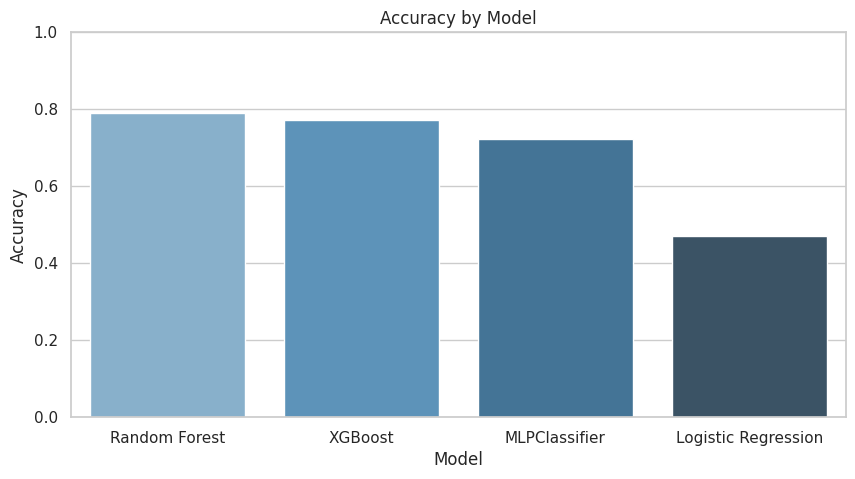

/tmp/ipykernel_27789/1335254181.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Macro F1 Score', data=results_df, palette='Greens_d')


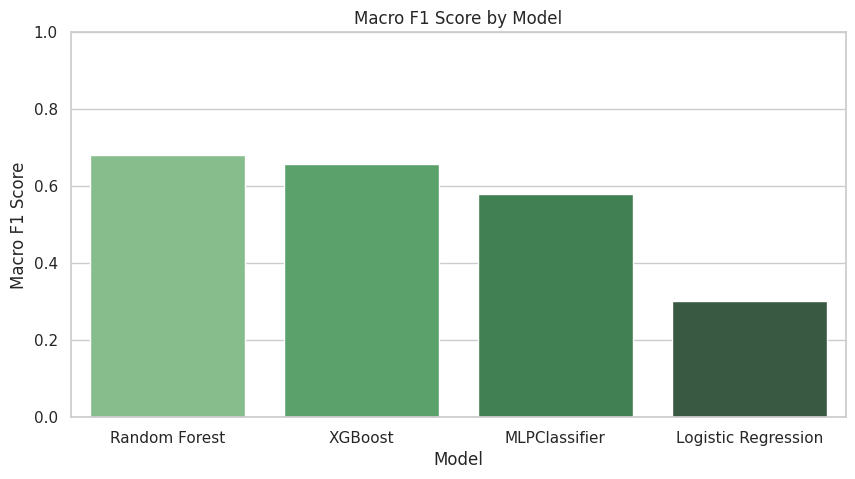

In [32]:
plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='Accuracy', data=results_df, palette='Blues_d')
plt.title("Accuracy by Model")
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='Macro F1 Score', data=results_df, palette='Greens_d')
plt.title("Macro F1 Score by Model")
plt.ylim(0, 1)
plt.show()


### STEP 9 Save Trained Models into `models/` Folder

We'll save:
- All trained models (XGBoost, RF, MLP, Logistic)
- Feature names

The `models/` directory will hold:
- `xgb_model.pkl`
- `rf_model.pkl`
- `log_model.pkl`
- `mlp_model.h5`
- `feature_names.pkl`

In [36]:
# Create directory if not exists
os.makedirs("../models", exist_ok=True)

# Save traditional ML models as .pkl
with open("../models/xgb_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

with open("../models/rf_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)

with open("../models/log_model.pkl", "wb") as f:
    pickle.dump(log_model, f)

with open("../models/mlp_model.pkl", "wb") as f:
    pickle.dump(mlp_model, f)

# Save feature list as .pkl
with open("../models/feature_names.pkl", "wb") as f:
    pickle.dump(X_train.columns.tolist(), f)

print("All models and feature names saved in 'models/' as .pkl and .h5 formats.")


All models and feature names saved in 'models/' as .pkl and .h5 formats.
